In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

/home/nakagawaren/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

# Prediction Import

In [3]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
df = pd.read_csv('predict.csv', index_col=0)
predict = df.drop('true', axis=1)
true = df['true']
del df
true_encoded = true.map(lambda x: LABELS[x])
true_encoded.name = 'true_label'
predict.columns = LABELS
predict.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking
0,2.959666,-6.737992,-6.380296,-8.474016,2.319753,7.336327
1,-3.291186,-3.465720,21.066204,5.942727,-1.329562,-4.152183
2,5.078833,-11.848777,-9.972389,-4.688415,6.694506,3.981413
3,2.140176,17.910784,-2.582074,-2.704649,0.710495,-12.348987
4,-1.383354,-4.894987,3.321186,20.915627,-4.230666,0.415444


In [4]:
# min-max normalization
predict = predict.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)
predict = predict.apply(lambda x: x / x.sum(), axis=1)

predict_label = predict.idxmax(axis=1)
predict_probability = predict.max(axis=1)
predict_probability.name = 'predict_probability'
predict_label.name = 'predict_label'
# predict.head()
# true.head()
# true_encoded.head()

In [5]:
df = pd.concat([
            predict,
            predict_probability,
            true,
            predict_label,
            true_encoded
        ], axis=1)
df.head(10)

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,true,predict_label,true_label
0,0.273092,0.041465,0.050008,0.000000,0.257808,0.377628,0.377628,5,Walking,Walking
1,0.021697,0.017298,0.635490,0.254386,0.071129,0.000000,0.635490,2,Sitting,Sitting
2,0.280547,0.000000,0.031098,0.118671,0.307324,0.262359,0.307324,4,Upstairs,Upstairs
3,0.187636,0.391866,0.126482,0.124895,0.169121,0.000000,0.391866,1,Jogging,Jogging
4,0.080703,0.000000,0.188820,0.593168,0.015267,0.122042,0.593168,3,Standing,Standing
5,0.072073,0.165525,0.000000,0.031944,0.135069,0.595390,0.595390,5,Walking,Walking
6,0.461742,0.173757,0.001516,0.039319,0.323666,0.000000,0.461742,0,Downstairs,Downstairs
7,0.340128,0.000000,0.131043,0.151954,0.196103,0.180772,0.340128,0,Downstairs,Downstairs
8,0.196132,0.539599,0.104126,0.144983,0.000000,0.015160,0.539599,1,Jogging,Jogging
9,0.082587,0.239812,0.000000,0.163441,0.010719,0.503440,0.503440,5,Walking,Walking


Accuracy:  0.9328639067621707


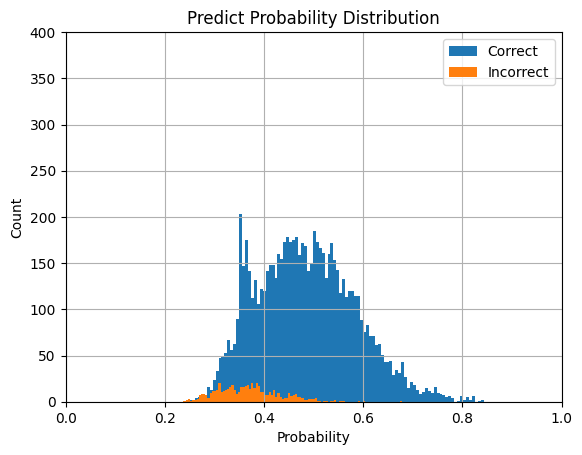

In [6]:
print('Accuracy: ', calc_accuracy(df))
# statival analysis
df.loc[df.true_label==df.predict_label, 'predict_probability'].hist(bins=100)
df.loc[df.true_label!=df.predict_label, 'predict_probability'].hist(bins=100)
plt.title('Predict Probability Distribution')
plt.xlim(0, 1)
plt.ylim(0, 400)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend(['Correct', 'Incorrect'])

In [7]:
df['predict_probability'].agg(['mean', 'std', 'min', 'max', 'median'])

mean      0.476542
std       0.101502
min       0.237453
max       0.842861
median    0.470394
Name: predict_probability, dtype: float64

In [8]:
thresholds = [0, 0.3, 0.4, 0.5, 0.6, 0.7]
results = []
for threshold in thresholds:
    df_confidence = df[df['predict_probability'] > threshold]
    df_drop = df.loc[list(set(df.index) - set(df_confidence.index)),:]
    results.append({
        'threshold': threshold,
        'confidence_accuracy': calc_accuracy(df_confidence),
        'confidence_raito': len(df_confidence) / len(df),
        'drop_accuracy': calc_accuracy(df_drop),
        'drop_ratio': len(df_drop) / len(df),
        })
    # cm = confusion_matrix(df_confidence['true_label'], df_confidence['predict_label'])
    # cm_df = pd.DataFrame(cm, index=LABELS, columns=LABELS)
    # plt.figure(figsize=(10, 10))
    # sns.heatmap(
    #     cm_df,
    #     annot=True,
    #     fmt="d",
    #     linewidths=0.5,
    #     cmap="Blues",
    #     cbar=False,
    #     annot_kws={"size": 14},
    #     square=True,
    # )
    # plt.title(f"Confusion Matrix (threshold={threshold})")
    # plt.ylabel("True label")
    # plt.xlabel("Predicted label")
    # plt.savefig(f'confusion_matrix/threshold{threshold}.png')
    # plt.close()
results = pd.DataFrame(results).fillna(0)
results = results.set_index('threshold')
results

/tmp/ipykernel_11587/3327794854.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,confidence_accuracy,confidence_raito,drop_accuracy,drop_ratio
threshold,,,,
0.0,0.932864,1.000000,0.000000,0.000000
0.3,0.940857,0.983246,0.463768,0.016754
0.4,0.975282,0.741654,0.811090,0.258346
0.5,0.993961,0.402088,0.891777,0.597912
0.6,0.997925,0.117033,0.924240,0.882967
0.7,1.000000,0.020274,0.931475,0.979726


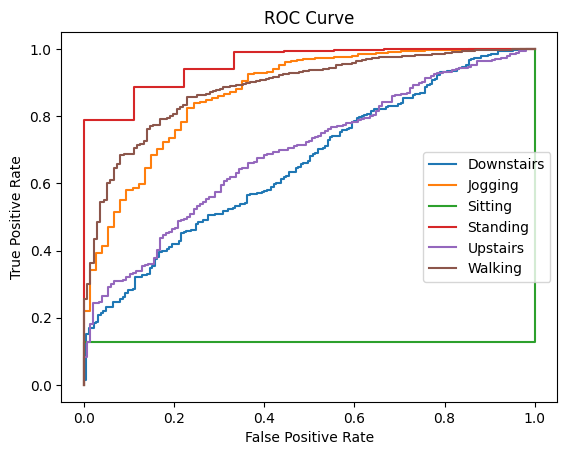

In [9]:
from sklearn.metrics import roc_curve

for label in LABELS:
    fpr, tpr, thresholds = roc_curve(df.loc[df.predict_label==label, 'true_label'], df.loc[df.predict_label==label, "predict_probability"], pos_label=label)
    plt.plot(fpr, tpr, label=label)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Each Label Prediction Probability of histgram

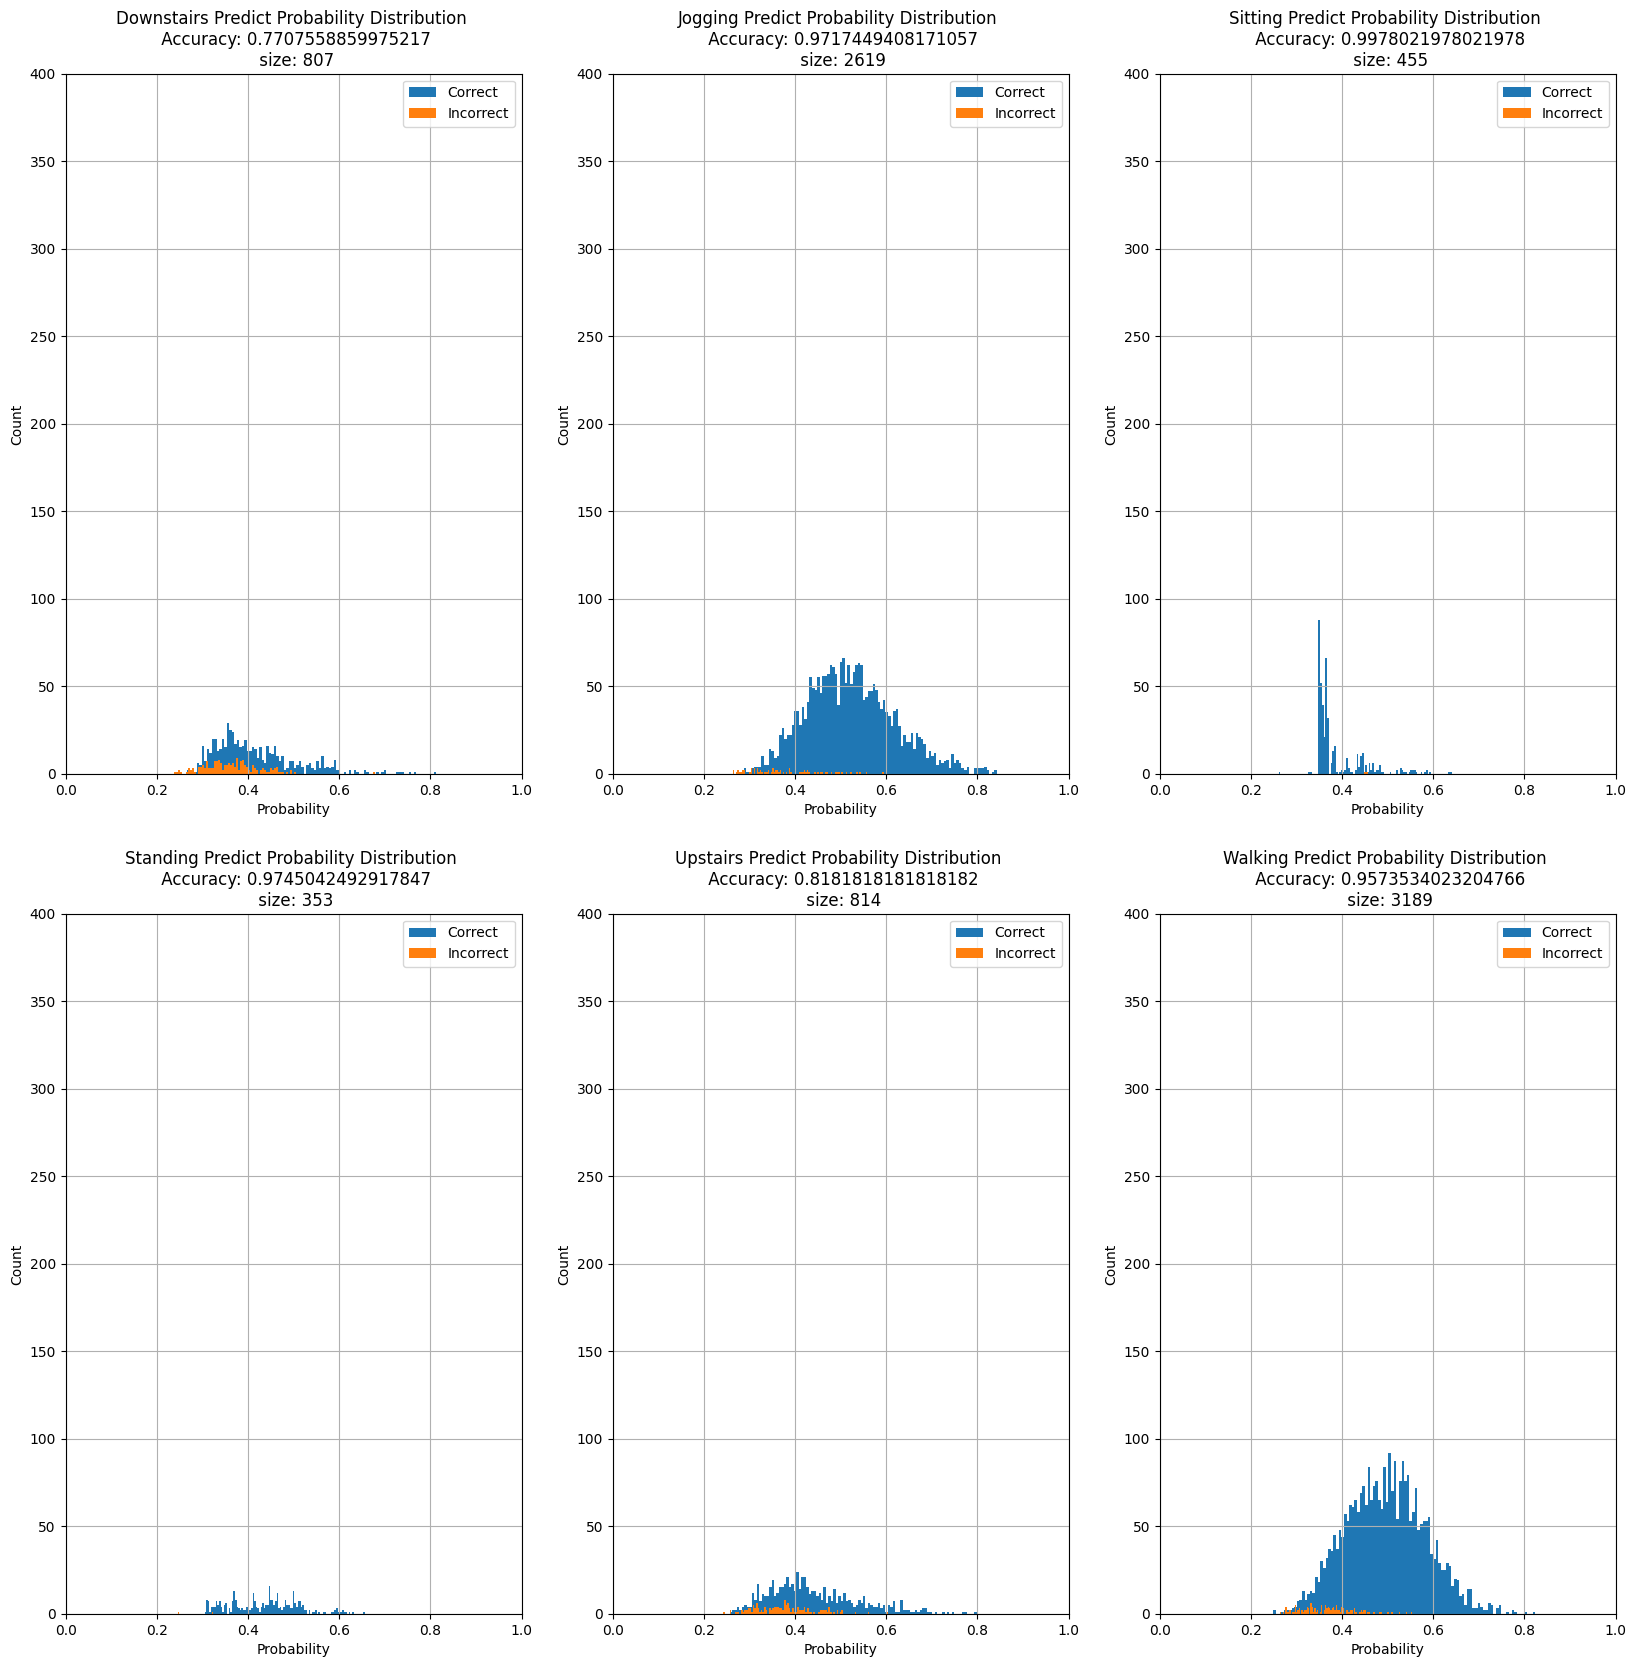

In [10]:
fig, axs = plt.subplots(2, 3, figsize=(20, 20))

for i, label in enumerate(LABELS):
    df_label = df.loc[df.predict_label==label, :]
    df_label.loc[df_label.true_label==df_label.predict_label, 'predict_probability'].hist(bins=100, ax=axs[i//3][i%3])
    df_label.loc[df_label.true_label!=df_label.predict_label, 'predict_probability'].hist(bins=100, ax=axs[i//3][i%3])
    axs[i//3][i%3].set_title(f"{label} Predict Probability Distribution \n Accuracy: {calc_accuracy(df_label)}\n size: {len(df_label)}")
    axs[i//3][i%3].set_xlim(0, 1)
    axs[i//3][i%3].set_ylim(0, 400)
    axs[i//3][i%3].set_xlabel('Probability')
    axs[i//3][i%3].set_ylabel('Count')
    axs[i//3][i%3].legend(['Correct', 'Incorrect'])
# plt.tight_layout()
plt.show()